In [36]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [37]:
import gdown

In [35]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /Users/liranpod/Desktop/Tensorflow/Computer Vision/Lip Reader/data.zip
 17%|██████▊                                | 73.9M/423M [00:11<00:54, 6.46MB/s]

KeyboardInterrupt: 

In [38]:
def load_video(path:str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [139]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'!?123456789 "]

In [140]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f'The vocabulary is: {char_to_num.get_vocabulary()}'
      f' (Size = {char_to_num.vocab_size()})')

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '!', '?', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (Size = 40)


In [141]:
char_to_num(["l", "i", "r", "a", "n"])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([12,  9, 18,  1, 14])>

In [142]:
num_to_char([12,  9, 18,  1, 14])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'l', b'i', b'r', b'a', b'n'], dtype=object)>

In [143]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [144]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split("/")[-1].split(".")[0]
    video_path = os.path.join("Data", "s1", f'{file_name}.mpg')
    alignment_path = os.path.join("Data", "alignments", "s1", f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [145]:
test_path = "./Data/s1/bbal6n.mpg"

In [146]:
tf.convert_to_tensor(test_path).numpy().decode("UTF-8").split("/")

['.', 'Data', 's1', 'bbal6n.mpg']

In [147]:
tf.convert_to_tensor(test_path).numpy().decode("UTF-8").split("/")[-1].split(".")[0]

'bbal6n'

In [148]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [149]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.19734782],
         [ 0.07893913]],

        [[ 1.4603739 ],
         [ 1.4603739 ],
         [ 1.4209043 ],
         ...,
         [ 0.15787826],
         [ 0.07893913],
         [ 0.03946957]],

        [[ 1.4209043 ],
         [ 1.4209043 ],
         [ 1.3814348 ],
         ...,
         [ 0.07893913],
         [ 0.07893913],
         [ 0.07893913]],

        ...,

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.94633   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.867392  ],
         [ 9.867392  ]],

        [[ 0.94726956],
         [ 0.94726956],
         [ 0.94726956],
         ...,
         [ 9.90686   ],
         [ 9.86739

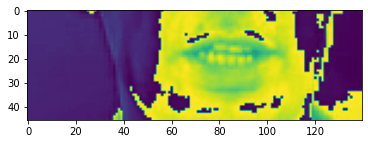

In [150]:
plt.imshow(frames[40])

In [151]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [152]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [153]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [189]:
data = tf.data.Dataset.list_files("./Data/s1/*.mpg")
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [190]:
frames, alignments = data.as_numpy_iterator().next()

In [191]:
len(frames)

2

In [192]:
alignments # Trailing 0's as padded

array([[19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  2, 25, 39, 15, 39, 14,
         9, 14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8, 39, 16,
        39,  6, 15, 21, 18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [193]:
test = data.as_numpy_iterator()

In [194]:
val = test.next(); val[0] # Frames

array([[[[[1.4227918 ],
          [1.4227918 ],
          [1.384338  ],
          ...,
          [9.113559  ],
          [9.382735  ],
          [9.421189  ]],

         [[1.4227918 ],
          [1.4227918 ],
          [1.384338  ],
          ...,
          [8.72902   ],
          [9.344282  ],
          [9.5365505 ]],

         [[1.3074304 ],
          [1.3074304 ],
          [1.3074304 ],
          ...,
          [9.575005  ],
          [0.03845384],
          [0.03845384]],

         ...,

         [[0.96134585],
          [0.96134585],
          [0.92289203],
          ...,
          [9.767274  ],
          [9.767274  ],
          [9.767274  ]],

         [[0.96134585],
          [0.96134585],
          [0.92289203],
          ...,
          [9.651913  ],
          [9.690367  ],
          [9.690367  ]],

         [[0.96134585],
          [0.96134585],
          [0.92289203],
          ...,
          [9.651913  ],
          [9.690367  ],
          [9.690367  ]]],


        [[[1.2689

In [197]:
imageio.mimsave('./animation.gif', val[0][1], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.04981803894043]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.04981803894043]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.04981803894043]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.04981803894043]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.04981803894043]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.04981803894043]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.04981803894043]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

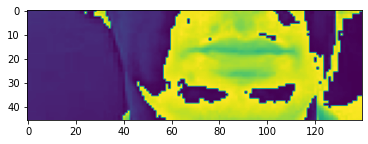

In [198]:
plt.imshow(val[0][0][74]) # Last frame of the first video

In [199]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue at n four please'>

In [200]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, Activation, MaxPool3D, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [201]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [202]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1,2,2)))
          
model.add(Conv3D(256, 3, padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1,2,2)))
          
model.add(Conv3D(75, 3, padding="same"))
model.add(Activation("relu"))
model.add(MaxPool3D((1,2,2)))
          
model.add(TimeDistributed(Flatten()))
          
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))
          
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))
          
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [203]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_13 (Conv3D)          (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_13 (Activation)  (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 75, 23, 70, 128)  0         
 g3D)                                                            
                                                                 
 conv3d_14 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_14 (Activation)  (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 75, 11, 35, 256)  0         
 g3D)                                                 

In [204]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [205]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b"bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb'''''''''''bbbbbbbbbbbbbbbb''''rrrr''''6">

In [206]:
model.input_shape

(None, 75, 46, 140, 1)

In [207]:
model.output_shape

(None, 75, 41)

In [208]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [209]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [215]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [216]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [217]:
checkpoint_callback = ModelCheckpoint(os.path.join('Models','Checkpoint'), monitor='loss', save_weights_only=True) 

In [218]:
schedule_callback = LearningRateScheduler(scheduler)

In [219]:
example_callback = ProduceExample(test)

In [220]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  6/450 [..............................] - ETA: 3:28:08 - loss: 168.9500

KeyboardInterrupt: 

In [221]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /Users/liranpod/Desktop/Tensorflow/Computer Vision/Lip Reader/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:14<00:00, 6.36MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [222]:
model.load_weights('Models/checkpoint')

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.